# YouTube Channel Analytics Project

## Overview
This notebook handles the data collection and preparation for the YouTube Channel Analytics project. We use the YouTube Data API to gather channel statistics and video details from various channels and prepare this data for analysis.

## Setup
First, we import the necessary libraries and set up the YouTube Data API client.

In [1]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import isodate
from isodate import parse_duration


## Configuration
Here, we configure the YouTube API key and specify the channel IDs we are interested in.

In [2]:
api_key = 'Your API Key here'
channel_ids = ['UCNyxrRXa3PvyJYuFP51iU-Q', 'UC6uX6GF5q2JxLjMkyivM2Og', 'UC_F4Iy5korq2mEWZDQhG07w', 'UCmzxts0YGES5tN-oJ9abTQg',
               'UCo_q6aOlvPH7M-j_XGWVgXg', 'UCeYue9Nbodzg3T1Nt88E3fg', 'UCBAtiokiAR1D320knY_yXyQ', 'UC4qa5EroJxnQM6Sng9WhgsQ' ]
youtube = build('youtube', 'v3', developerKey=api_key)


## Fetching Channel Statistics
We define a function to retrieve statistics for each channel, including the number of subscribers, views, and total videos. The get_channel_stats function queries the API and processes the response.

In [3]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(part="snippet,contentDetails,statistics", id=','.join(channel_ids))
    response = request.execute()
    for i in range(len(response['items'])):
        data = {'channel_name': response['items'][i]['snippet']['title'],
                'subscribers': response['items'][i]['statistics']['subscriberCount'],
                'views': response['items'][i]['statistics']['viewCount'],
                'total_videos': response['items'][i]['statistics']['videoCount'],
                'playlist_id': response['items'][i]['contentDetails']['relatedPlaylists']['uploads']}
        all_data.append(data)
    
    return all_data


We then retrieve the channel statistics and load them into a DataFrame.



In [4]:
channel_stats = get_channel_stats(youtube, channel_ids)
df = pd.DataFrame(channel_stats)


## Data Preprocessing
We ensure that the columns in the DataFrame are of the correct data types.

In [5]:
df['subscribers'] = pd.to_numeric(df['subscribers'])
df['views'] = pd.to_numeric(df['views'])
df['total_videos'] = pd.to_numeric(df['total_videos'])


We ensure that the DataFrame is in order before we move on to data visualization.

In [6]:
df

,channel_name,subscribers,views,total_videos,playlist_id
0,Ho & Pringle Productions,90200,30048393,323,UUeYue9Nbodzg3T1Nt88E3fg
1,Italo Ferreira,87500,7764420,163,UUBAtiokiAR1D320knY_yXyQ
2,Nathan Florence,474000,219518331,532,UU6uX6GF5q2JxLjMkyivM2Og
3,Ben Gravy,201000,72705097,2164,UU4qa5EroJxnQM6Sng9WhgsQ
4,Koa Rothman,201000,51598520,517,UU_F4Iy5korq2mEWZDQhG07w
5,Jamie O'Brien,1270000,502351997,956,UUo_q6aOlvPH7M-j_XGWVgXg
6,John John Florence,197000,32021763,160,UUNyxrRXa3PvyJYuFP51iU-Q
7,Kai Lenny,145000,41871035,199,UUmzxts0YGES5tN-oJ9abTQg


## Data Visualization
We use Seaborn to visualize the statistics for each channel.

We can see that the distinct channels have a broad range of subscribers 

Text(0.5, 1.0, 'Channels Subscribers Count')

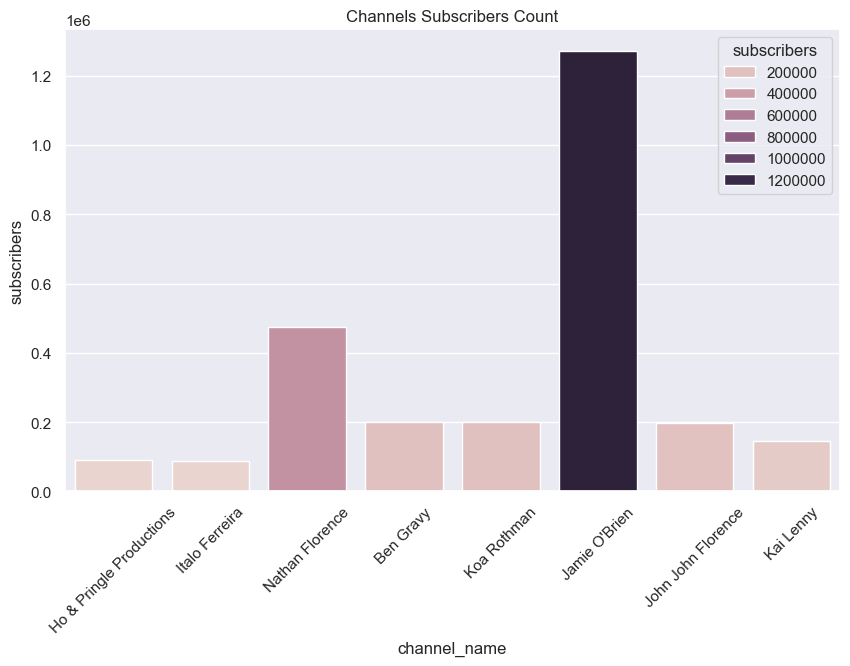

In [7]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x='channel_name', y='subscribers', data=df, hue="subscribers")
ax.tick_params(axis='x', rotation=45)
ax.set_title('Channels Subscribers Count')

Text(0.5, 1.0, 'Channels Total View Count')

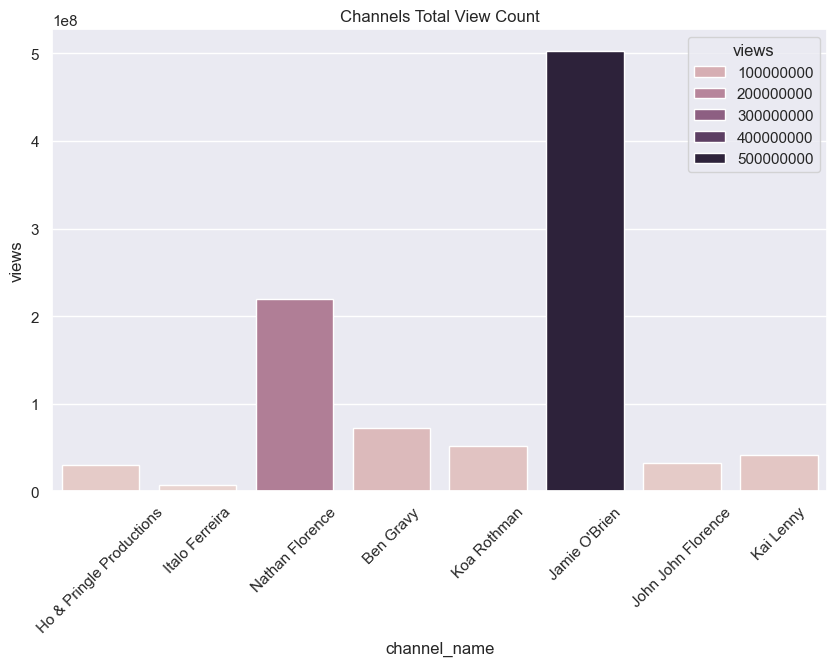

In [8]:
ax = sns.barplot(x='channel_name', y='views', data=df, hue="views")
ax.tick_params(axis='x', rotation=45)
ax.set_title('Channels Total View Count')

Text(0.5, 1.0, 'Channels Total Videos Count')

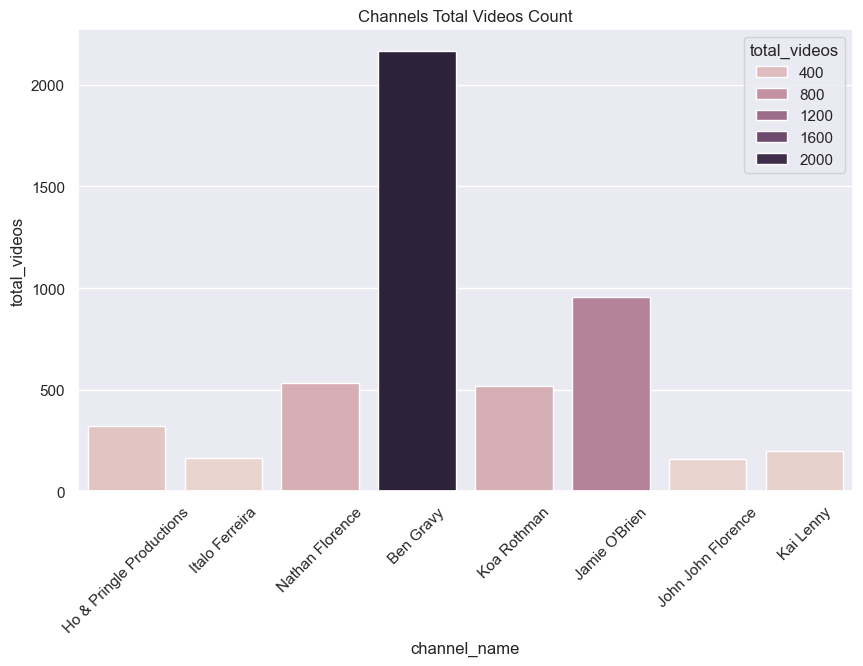

In [9]:
ax = sns.barplot(x='channel_name', y='total_videos', data=df, hue="total_videos")
ax.tick_params(axis='x', rotation=45)
ax.set_title('Channels Total Videos Count')

## Fetching Video Data
We define functions to retrieve video IDs and video details from each channel's playlist.

In [10]:
def get_video_ids(youtube, playlist_id):
    video_ids = []
    next_page_token = None
    more_pages = True
    while more_pages:
        request = youtube.playlistItems().list(part="contentDetails", maxResults=50, playlistId=playlist_id, pageToken=next_page_token)
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')
        if next_page_token is None:
            more_pages = False
    return video_ids

def get_video_details(youtube, videos):
    video_details = []
    for i in range(0, len(videos), 50):
        request = youtube.videos().list(part="snippet,contentDetails,statistics", id=','.join(videos[i:i+50]))
        response = request.execute()
        for video in response['items']:
            video_dict = {
                'Video_id': video['id'],
                'Title': video['snippet'].get('title', 'Unknown Title'),
                'Published_date': video['snippet'].get('publishedAt', 'Unknown Date'),
                'Views': video['statistics'].get('viewCount', '0'),
                'Likes': video['statistics'].get('likeCount', '0'),
                'Comments': video['statistics'].get('commentCount', '0'),
                'Duration': video['contentDetails'].get('duration', 'Unknown Duration')
            }
            video_details.append(video_dict)
    return video_details


We then fetch all video data and process it into a DataFrame.



In [11]:
def fetch_video_data(row):
    video_ids = get_video_ids(youtube, row['playlist_id'])
    video_details = get_video_details(youtube, video_ids)
    video_details_df = pd.DataFrame(video_details)
    video_details_df['channel_name'] = row['channel_name']
    return video_details_df

video_data = df.apply(fetch_video_data, axis=1)
all_channels_video_data = pd.concat(video_data.values, ignore_index=True)


## Data Preprocessing and Integrity Check
We process the video data, ensuring the correct data types and checking for any issues such as missing values or negative numbers.

In [12]:
all_channels_video_data['Published_date'] = pd.to_datetime(all_channels_video_data['Published_date'])
all_channels_video_data['Views'] = pd.to_numeric(all_channels_video_data['Views'])
all_channels_video_data['Likes'] = pd.to_numeric(all_channels_video_data['Likes'])
all_channels_video_data['Comments'] = pd.to_numeric(all_channels_video_data['Comments'])
all_channels_video_data['Duration'] = all_channels_video_data['Duration'].apply(parse_duration)
all_channels_video_data['Month'] = all_channels_video_data['Published_date'].dt.strftime('%b')

In [13]:
# We ensure there are no missing values
all_channels_video_data.isnull().sum()

Video_id          0
Title             0
Published_date    0
Views             0
Likes             0
Comments          0
Duration          0
channel_name      0
Month             0
dtype: int64

In [14]:
# We ensure that all columns are in the correct format
all_channels_video_data.dtypes

Video_id                       object
Title                          object
Published_date    datetime64[ns, UTC]
Views                           int64
Likes                           int64
Comments                        int64
Duration              timedelta64[ns]
channel_name                   object
Month                          object
dtype: object

In [15]:
## We define the order of months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# We convert 'month' to a categorical type with the defined order
all_channels_video_data['Month'] = pd.Categorical(all_channels_video_data['Month'], categories=month_order, ordered=True)

In [16]:
# We check 'month' type again after Converting 'month' to a categorical type with the defined order
all_channels_video_data['Month'].dtypes

CategoricalDtype(categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                  'Sep', 'Oct', 'Nov', 'Dec'],
, ordered=True, categories_dtype=object)

In [17]:
# We check if the number of videos per channel correlates to the original DataFrame prior to the Concatenation
all_channels_video_data['channel_name'].value_counts()

channel_name
Ben Gravy                   2165
Jamie O'Brien                956
Nathan Florence              533
Koa Rothman                  517
Ho & Pringle Productions     323
Kai Lenny                    199
Italo Ferreira               164
John John Florence           160
Name: count, dtype: int64

In [18]:
# We check for duplicate rows
all_channels_video_data.duplicated().sum()

0

In [19]:
# We ensure that the dates in 'Published_date' column are within a reasonable range:
min_date = all_channels_video_data['Published_date'].min()
max_date  = all_channels_video_data['Published_date'].max()
min_date, max_date 

(Timestamp('2007-11-12 13:23:36+0000', tz='UTC'),
 Timestamp('2024-08-29 14:00:06+0000', tz='UTC'))

In [20]:
# We check for negative values
filtered_df = all_channels_video_data[['Views', 'Likes', 'Comments']]
negative_mask = (filtered_df<0).any(axis=1)
rows_with_negative_vals = filtered_df[negative_mask]
len(rows_with_negative_vals)

0

In [21]:
# We check unique values in 'month' column
all_channels_video_data['Month'].unique()

['Aug', 'Jul', 'Jun', 'May', 'Apr', ..., 'Jan', 'Dec', 'Nov', 'Oct', 'Sep']
Length: 12
Categories (12, object): ['Jan' < 'Feb' < 'Mar' < 'Apr' ... 'Sep' < 'Oct' < 'Nov' < 'Dec']

In [22]:
# We review a sample of the data to ensure that it looks as expected:
all_channels_video_data

,Video_id,Title,Published_date,Views,Likes,Comments,Duration,channel_name,Month
0,7_2cuckjs1M,High Noon | A SURF RANCH Snapt Takeover Starri...,2024-08-23 14:15:09+00:00,55812,728,91,0 days 00:22:01,Ho & Pringle Productions,Aug
1,2CLmMDXpMUw,Mason Ho POV Desert Point Special Guest Sledge...,2024-08-16 19:00:36+00:00,27671,658,53,0 days 00:08:03,Ho & Pringle Productions,Aug
2,9UPDrEsULKQ,Rocky Point Surf With Special Guest Sledge Ham...,2024-08-11 01:50:17+00:00,78910,1075,72,0 days 00:08:02,Ho & Pringle Productions,Aug
3,_B1ZBI0mVgU,Summertime Rides With The kids,2024-08-02 20:43:36+00:00,5947,223,0,0 days 00:04:12,Ho & Pringle Productions,Aug
4,XItO4texa8k,Ho Family & Friends Surf SOLID Ala Moana Bowl,2024-07-26 16:14:54+00:00,42377,755,81,0 days 00:17:14,Ho & Pringle Productions,Jul
...,...,...,...,...,...,...,...,...,...
5012,YlVs_cD7bzI,Kai Hydrofoil Surfing the North Shore,2016-12-18 23:02:18+00:00,72633,378,20,0 days 00:02:20,Kai Lenny,Dec
5013,SvISdYzhZCI,Kai Lenny Tow-Surfing after the Peahi Challenge,2016-11-12 23:49:31+00:00,168490,1225,83,0 days 00:01:57,Kai Lenny,Nov
5014,h7XupqFOFSg,Worlds Longest Waves: Open Ocean Foil Surfing,2016-09-14 19:18:50+00:00,214825,887,51,0 days 00:02:01,Kai Lenny,Sep
5015,px88XsARHwc,Kai Lenny Hydrofoil Surfing,2016-07-05 17:33:54+00:00,1262797,3859,156,0 days 00:03:00,Kai Lenny,Jul


In [23]:
# We reorder the Columns as we wish
# We define the desired column order
columns_order = ['channel_name', 'Title', 'Video_id', 'Published_date', 'Month', 'Views', 'Likes', 'Comments', 'Duration']

# We reorder the columns of the DataFrame according to the specified order
all_channels_video_data = all_channels_video_data[columns_order]

In [24]:
# We check that all columns are in the desired dtypes
all_channels_video_data.dtypes

channel_name                   object
Title                          object
Video_id                       object
Published_date    datetime64[ns, UTC]
Month                        category
Views                           int64
Likes                           int64
Comments                        int64
Duration              timedelta64[ns]
dtype: object

In [25]:
# We review a sample of the data to ensure that it looks as expected:
all_channels_video_data

,channel_name,Title,Video_id,Published_date,Month,Views,Likes,Comments,Duration
0,Ho & Pringle Productions,High Noon | A SURF RANCH Snapt Takeover Starri...,7_2cuckjs1M,2024-08-23 14:15:09+00:00,Aug,55812,728,91,0 days 00:22:01
1,Ho & Pringle Productions,Mason Ho POV Desert Point Special Guest Sledge...,2CLmMDXpMUw,2024-08-16 19:00:36+00:00,Aug,27671,658,53,0 days 00:08:03
2,Ho & Pringle Productions,Rocky Point Surf With Special Guest Sledge Ham...,9UPDrEsULKQ,2024-08-11 01:50:17+00:00,Aug,78910,1075,72,0 days 00:08:02
3,Ho & Pringle Productions,Summertime Rides With The kids,_B1ZBI0mVgU,2024-08-02 20:43:36+00:00,Aug,5947,223,0,0 days 00:04:12
4,Ho & Pringle Productions,Ho Family & Friends Surf SOLID Ala Moana Bowl,XItO4texa8k,2024-07-26 16:14:54+00:00,Jul,42377,755,81,0 days 00:17:14
...,...,...,...,...,...,...,...,...,...
5012,Kai Lenny,Kai Hydrofoil Surfing the North Shore,YlVs_cD7bzI,2016-12-18 23:02:18+00:00,Dec,72633,378,20,0 days 00:02:20
5013,Kai Lenny,Kai Lenny Tow-Surfing after the Peahi Challenge,SvISdYzhZCI,2016-11-12 23:49:31+00:00,Nov,168490,1225,83,0 days 00:01:57
5014,Kai Lenny,Worlds Longest Waves: Open Ocean Foil Surfing,h7XupqFOFSg,2016-09-14 19:18:50+00:00,Sep,214825,887,51,0 days 00:02:01
5015,Kai Lenny,Kai Lenny Hydrofoil Surfing,px88XsARHwc,2016-07-05 17:33:54+00:00,Jul,1262797,3859,156,0 days 00:03:00


## Saving the Data
Finally, we save the cleaned DataFrame to a CSV file for further analysis.

In [26]:
all_channels_video_data.to_csv('C:\YT Analysis Project/all_channels_video_data1.csv', index=False)